# Aula prática - Filtros
* Disciplina: Sistemas de comunicação
* Professor: Carmelo José Albanez Bastos Filho
* Estagiário: Gabriel Alves de Lima (gal@ecomp.poli.br)

## O que são filtros?
Filtros são componentes que são capazes de remover componentes indesejados ou evidenciar características de um sinal. Em sistemas de comunicação, são normalmente utilizados para *separar componentes de informação* ou *corrigir distorções*, por exemplo. Um filtro de linhas transversais funciona pela _convolução_ do sinal de entrada com seus coeficientes, ou seja, as amostras do sinal de entrada são colocadas, uma a uma, em linhas de atraso ponderadas e seus resultados são somados.

<figure class="image">
  <img src="static/image/filtro_transversal.png" alt="Diagrama de blocos de um filtro de linhas transversais">
  <figcaption>Figura 1: Diagrama de blocos de um filtro de linhas transversais</figcaption>
</figure>

Vamos ver na aula de hoje como podemos implementar filtros (utilizando python) e utilizá-los para remover dados indesejados de sinais.

## Sinais
Antes de estudarmos diretamente com filtros, vamos primeiro entender como podemos representar sinais. Assim, poderemos criar diferentes sinais para filtrarmos mais adiante.

### Amostragem
Os sinais não podem ser representados como sinais contínuos dentro de um computador, pois simplesmente não existe memória infinita para representar o domínio (e.g. tempo) sem antes definir uma maneira de tornar este discreto. Existe, no entanto, uma forma simples de pensar nisso.
Amostrar um sinal é representar este como uma sequência de amostras espaçadas igualmente. Desta forma, desde que o formato de onda seja mantido, as mesmas informações que estão presentes no sinal de domínio contínuo também estarão presentes no sinal de domínio discreto. Isto pode ser visto na Figura 2. A representação matemática da amostragem é a multiplicação de um sinal por um trem de impulsos separados entre si por um multiplo de uma constante (i.e. o período de amostragem).

<figure class="image">
  <img src="static/image/sinal_amostragem.png" alt="Amostragem de um sinal por um trem de impulsos">
  <figcaption>Figura 2: Amostragem de um sinal por um trem de impulsos.</figcaption>
</figure>

### Teorema da amostragem
Para que o formato de onda de um sinal após a coleta das amostras, existe um critério que é definido pelo chamado *teorema da amostragem* que indica a frequência mínima (ou período máximo) do trem de impulsos para que não ocorra perda de informação durante este processo. O critério define que *a taxa mínima de amostragem deve ser igual a frequência máxima presente no sinal*. Podemos assim citar alguns exemplos para demonstrar a aplicabilidade deste critério:
* Uma chamada telefônica tem como taxa de amostragem 8kHz, pois a voz humana muito dificilmente pode superar a marca de 4kHz. Logo, a frequência mínima de amostragem é de 8kHz.
* A taxa de amostragem de um CD de áudio é de 44.1kHz, pois a frequência máxima que o ouvido de um ser humano pode ouvir é de 20kHz, então, a taxa de amostragem mínima para poder representar todo a banda audível é de 40kHz.

### Implementação de sinais
Vamos começar a fazer um pouco de prática (usaremos python aqui). Primeiramente, vamos importar todas as bibliotecas necessárias para executarmos os experimentos. Basicamente vamos utilizar apenas 3 bibliotecas:
* *numpy*: criação de dados sintéticos (e.g. para criar os sinais) e operações matemáticas em coleções de dados.
* *scipy*: acesso a funções de auxílio para operações com sinais e filtros
* *matplotlib*: visualização dos dados

In [2]:
# Show plots below code (Specific to ipython notebooks)
%matplotlib inline

# Importing everything we are going to need
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile    # Useful for reading .wav audio files
from scipy import signal        # A handful of signal processing operations

Definiremos também algumas funções úteis para visualizar os dados. Não são tão importantes para entendermos o processo, mas precisamos definí-las antes de usarmos.

In [3]:
# Function to plot signal data
# Source: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html
def plot_signal(figure, title, labels, data):
    plt.figure(figure)
    plt.title(title)
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.plot(data[0], data[1])

# Function to plot data in frequency domain
# Source: https://www.mathworks.com/help/matlab/ref/fft.html
def plot_frequency(figure, data, sampling_rate):
    s = np.fft.fft(data)
    data_length = data.shape[0]
    p2 = np.abs(s / data_length)
    p1 = p2[0:int(round(data_length / 2))]
    p1[1:] = 2 * p1[1:];
    domain = sampling_rate * np.arange(0, data_length / 2) / data_length
    
    plt.figure(figure)
    plt.plot(domain, p1)

# Function to plot filter response
# Source: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html
def plot_filter_response(figure, f):
    plt.figure(figure)
    w, h = signal.freqz(f)

    fig, ax1 = plt.subplots()
    ax1.set_title('Digital filter frequency response')

    ax1.plot(w, 20 * np.log10(abs(h)), 'b')
    ax1.set_ylabel('Amplitude [dB]', color='b')
    ax1.set_xlabel('Frequency [rad/sample]')

    ax2 = ax1.twinx()
    angles = np.unwrap(np.angle(h))
    ax2.plot(w, angles, 'g')
    ax2.set_ylabel('Angle (radians)', color='g')
    ax2.grid()
    ax2.axis('tight')

Como primeiro exemplo, vamos criar sinais senoidais de diferentes frequências e depois criar um sinal mais complexo como a composição destes dois primeiros.

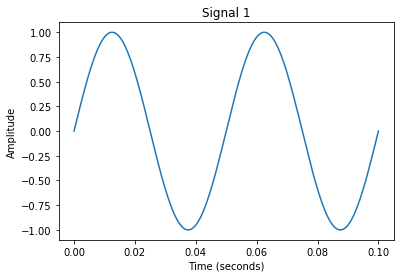

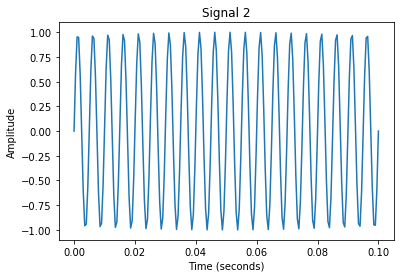

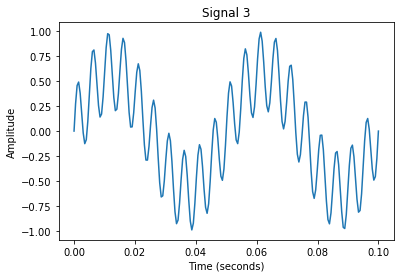

In [4]:
sampling_rate = 2000   # Hz
signal_duration = 0.1  # seconds

sampling_period = 1.0 / sampling_rate   # seconds
signal_domain = np.linspace(0, signal_duration, int(sampling_rate * signal_duration))

f1 = 20     # Hz
f2 = 200     # Hz

s1 = np.sin(2 * np.pi * signal_domain * f1) # A 20Hz sinusoid wave 
s2 = np.sin(2 * np.pi * signal_domain * f2) # A 200Hz sinusoid wave
s3 = 0.6 * s1 + 0.4 * s2   # A compound of the two waves defined earlier

# Plotting each signal
labels = ('Time (seconds)', 'Amplitude')
plot_signal(1, 'Signal 1', labels, (signal_domain, s1))
plot_signal(2, 'Signal 2', labels, (signal_domain, s2))
plot_signal(3, 'Signal 3', labels, (signal_domain, s3))

Podemos ver também como se comportam estes sinais no domínio da frequência. É útil para checar visualmente se estamos com sinais corretos.

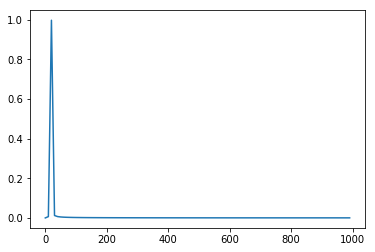

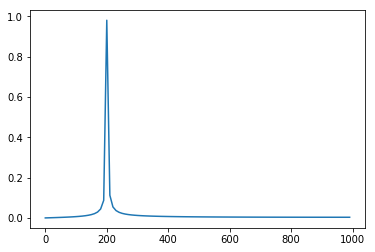

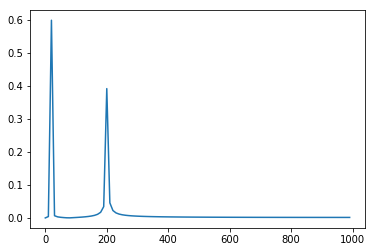

In [5]:
plot_frequency(1, s1, sampling_rate)
plot_frequency(2, s2, sampling_rate)
plot_frequency(3, s3, sampling_rate)

## Filtragem
Vamos agora ver como é realizado o processo de filtragem. Vamos fazer isto nos seguintes tópicos:

* Compreender como representar um filtro;
* implementar a função de convolução;
* construir um pipeline de processamento de sinais.

### Representação de um filtro

<Figure size 432x288 with 0 Axes>

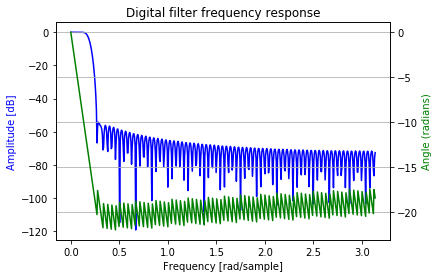

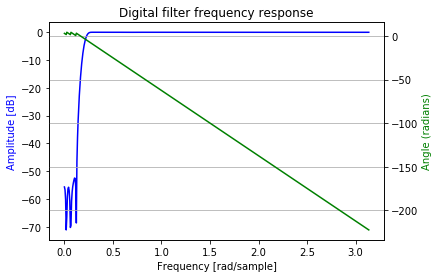

In [15]:
low_pass_filter = signal.firwin(151, 125.0 / sampling_rate)
high_pass_filter = signal.firwin(151, 125.0 / sampling_rate, pass_zero=False)

plot_filter_response(3, low_pass_filter)
plot_filter_response(4, high_pass_filter)

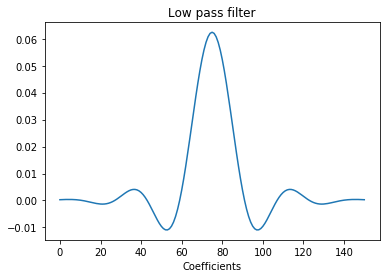

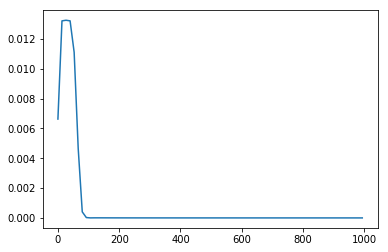

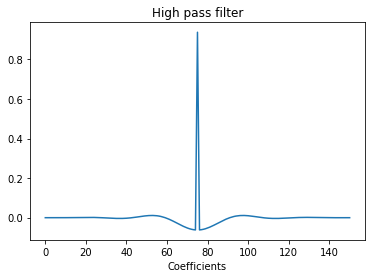

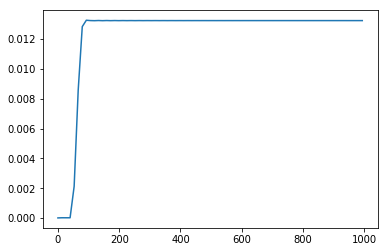

In [16]:
low_pass_domain = np.arange(0, low_pass_filter.shape[0])
plot_signal(1, 'Low pass filter', ('Coefficients', ''), (low_pass_domain, low_pass_filter))
plot_frequency(2, low_pass_filter, sampling_rate)

high_pass_domain = np.arange(0, high_pass_filter.shape[0])
plot_signal(3, 'High pass filter', ('Coefficients', ''), (high_pass_domain, high_pass_filter))
plot_frequency(4, high_pass_filter, sampling_rate)

### Convolução
A operação de convolução pode ser definida de acordo com a equação abaixo. Esta pode ser interpretada como a projeção da forma de uma onda na outra, a medida que uma destas é deslocada no domínio. Quando o sinal está no domínio do tempo, fazemos com que as amostras sejam projetadas depois de linhas de atraso, assim como apresentado na Figura 1.

$$s(t)*h(t) = \int_{-\infty}^{\infty} s(\tau)h(t - \tau)d\tau$$

Vamos fazer um exemplo prático: convoluir $[4,2,3,1]$ com $[3,2,1]$:
<br/>
<br/>
<br/>
<figure class="image">
  <img src="static/image/convolution.png" alt="Exemplo de convolução">
  <figcaption>Figura 3: Exemplo de convolução</figcaption>
</figure>
<br/>

Para manter as coisas simples, a resolução acima mostra apenas até a 3ª iteração, mas é simples continuar a partir daí. Experimente! A resposta completa, para conferência, é $[12, 14, 17, 11, 5, 1]$.
Visto este exemplo, podemos implementar uma operação de convolução.

In [23]:
def convolve(x, h, full=True):
    xr = [0] * h.shape[0]
    
    def run(signal, regressor):
        y = []
        for sample in signal:
            regressor.insert(0, sample)
            regressor.pop()
            y.append(np.dot(np.array(regressor), h))
            
        return y
    
    y = np.array(run(x, xr) + run(np.zeros(h.shape[0] - 1), xr))
    if not full:
        y = y[h.shape[0]:y.shape[0] - h.shape[0]]
    return y

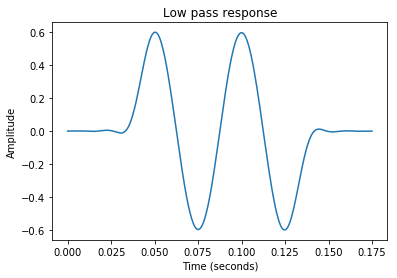

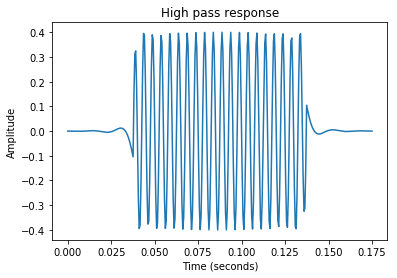

In [24]:
y1 = convolve(s3, low_pass_filter)
y2 = convolve(s3, high_pass_filter) 

labels = ('Time (seconds)', 'Amplitude')
domain_y1 = np.linspace(0, y1.shape[0] * sampling_period, y1.shape[0])
domain_y2 = np.linspace(0, y2.shape[0] * sampling_period, y2.shape[0])

plot_signal(1, 'Low pass response', labels, (domain_y1, y1))
plot_signal(2, 'High pass response', labels, (domain_y2, y2))

### Utilizando filtros em processamento de sinais acústicos
Vamos ver um último exemplo prático que consiste na aplicação de filtros para remoção de ruídos em arquivos de audio. Especificamente, temos disponível uma gravação de uma chamada telefônica e este arquivo de audio apresenta um ruído bastante agudo que iremos remover com filtros. Se pararmos para analisar o problema, podemos desenhar um simples diagrama (Figura 4) que representa uma possível solução.

<br/>
<br/>
<br/>
<figure class="image">
  <img src="static/image/pipeline.png" alt="Diagrama da solução do problema">
  <figcaption>Figura 4: Diagrama da solução do problema</figcaption>
</figure>
<br/>

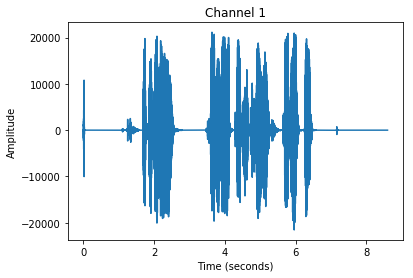

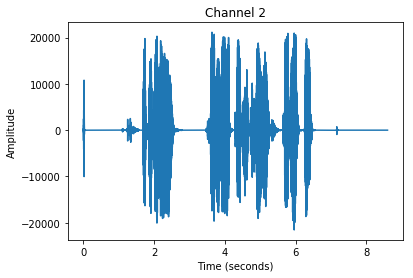

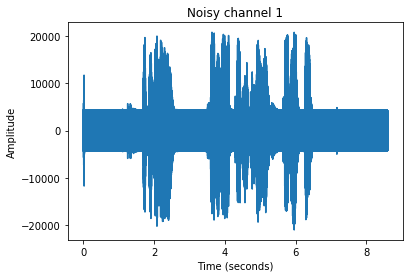

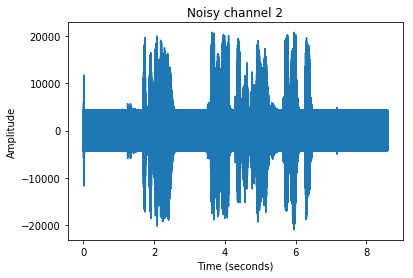

In [27]:
audio_sampling, stereo_data = wavfile.read('static/audio/mom.wav')

figure = 1

num_samples = stereo_data.shape[0]
num_channels = stereo_data.shape[1]
audio_duration = num_samples / audio_sampling   # seconds
audio_domain = np.linspace(0, audio_duration, num_samples)

for channel in range(num_channels):
    channel_data = stereo_data[:,channel]
    plot_signal(figure, 'Channel ' + str(channel + 1), labels, (audio_domain, channel_data))
    figure += 1
    
audio_sampling, stereo_data = wavfile.read('static/audio/noisy_mom.wav')

num_samples = stereo_data.shape[0]
num_channels = stereo_data.shape[1]
audio_duration = num_samples / audio_sampling   # seconds
audio_domain = np.linspace(0, audio_duration, num_samples)

for channel in range(num_channels):
    channel_data = stereo_data[:,channel]
    plot_signal(figure, 'Noisy channel ' + str(channel + 1), labels, (audio_domain, channel_data))
    figure += 1
 

Agora que conhecemos com o que vamos trabalhar, podemos começar a produzir nossa solução. Se utilizarmos um instrumento de medição, veremos que o ruído agudo é uma onda senoidal de 8kHz. Sabemos também que chamadas telefônicas são amostradas a 8kHz, logo, nunca vamos encontrar frequências maiores do que 4kHz. Portanto, se utilizarmos um filtro passa-baixa de 6kHz, o ruído será eliminado com certa folga.

<Figure size 432x288 with 0 Axes>

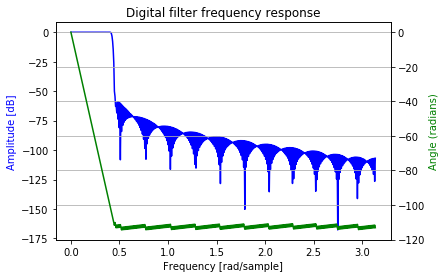

In [45]:
# Input
audio_sampling, stereo_data = wavfile.read('static/audio/noisy_mom.wav')
num_samples = stereo_data.shape[0]
num_channels = stereo_data.shape[1]
audio_duration = num_samples / audio_sampling   # seconds
max_value = np.abs(stereo_data).max()

# Preprocessing
normalized_stereo_data = stereo_data / max_value

# Filtering
channels = []
f = signal.firwin(500, 6000.0 / audio_sampling)
plot_filter_response(1, f)
for channel in range(num_channels):
    channels.append(convolve(normalized_stereo_data[:, channel], f))

# Output preparation
normalized_data = np.stack(channels, axis=1)
data = (normalized_data * max_value).astype(stereo_data.dtype)

# Output recording
wavfile.write('static/audio/filtered_mom.wav', audio_sampling, data)

# Exercícios
1. Produza um sinal que é o composto igualmente ponderado de quatro ondas senoidais (utilize 80Hz, 120Hz, 133Hz e 174Hz). Construa um filtro (ou uma série de filtros) capaz de manter apenas as ondas de 120Hz e 133Hz. Para comprovar que funciona, mostre o sinal resultante no domínio da frequência.
2. 

# Links úteis
* https://community.plm.automation.siemens.com/t5/Testing-Knowledge-Base/Introduction-to-Filters-FIR-versus-IIR/ta-p/520959